In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import logging 
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import distance
from collections import defaultdict
from math import sqrt
from multiprocessing.dummy import Pool as ThreadPool 
import numpy as np
from vanet_tools import plot_microclouds,Block,Node,Microcloud

In [29]:
df = pd.read_csv("sumo_out.csv",delimiter=";").dropna()
df.head()

,timestep_time,vehicle_angle,vehicle_id,vehicle_lane,vehicle_pos,vehicle_slope,vehicle_speed,vehicle_type,vehicle_x,vehicle_y
1,1.0,0.0,from0.0,0_0,5.1,0.0,0.0,SUMO_DEFAULT_TYPE,1.65,8.35
2,2.0,0.0,from0.0,0_0,5.9,0.0,0.8,SUMO_DEFAULT_TYPE,1.65,9.15
3,2.0,90.0,from1.0,1_0,5.1,0.0,0.0,SUMO_DEFAULT_TYPE,8.35,498.35
4,3.0,0.0,from0.0,0_0,7.5,0.0,1.6,SUMO_DEFAULT_TYPE,1.65,10.75
5,3.0,90.0,from1.0,1_0,5.9,0.0,0.8,SUMO_DEFAULT_TYPE,9.15,498.35


In [30]:
car_groups = df.sort_values(by='timestep_time').groupby('vehicle_id')

In [31]:
cars = df['vehicle_id'].unique()

In [32]:
car0_df = car_groups.get_group(cars[0])
car0_df.head()

,timestep_time,vehicle_angle,vehicle_id,vehicle_lane,vehicle_pos,vehicle_slope,vehicle_speed,vehicle_type,vehicle_x,vehicle_y
1,1.0,0.0,from0.0,0_0,5.1,0.0,0.0,SUMO_DEFAULT_TYPE,1.65,8.35
2,2.0,0.0,from0.0,0_0,5.9,0.0,0.8,SUMO_DEFAULT_TYPE,1.65,9.15
4,3.0,0.0,from0.0,0_0,7.5,0.0,1.6,SUMO_DEFAULT_TYPE,1.65,10.75
7,4.0,0.0,from0.0,0_0,9.9,0.0,2.4,SUMO_DEFAULT_TYPE,1.65,13.15
11,5.0,0.0,from0.0,0_0,13.1,0.0,3.2,SUMO_DEFAULT_TYPE,1.65,16.35


Below is a figure of how a sample car moves in the x and y coordinates

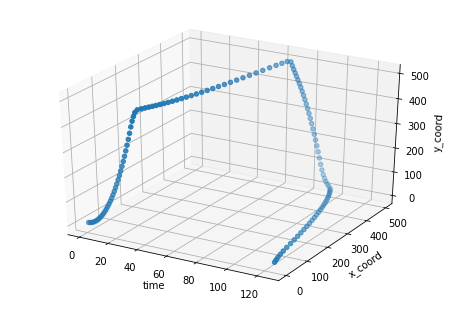

In [33]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(car0_df['timestep_time'],car0_df['vehicle_x'] , car0_df['vehicle_y'])
ax.set_xlabel("time")
ax.set_ylabel("x_coord")
ax.set_zlabel("y_coord")
plt.show()

The manual and hardest part of the simulation is positioning the microclouds. Note that below, we will position the microclouds in an algorithmic fashion; however, this algorithm may not be in fact the most optimal positioning as it does not take into account real life variables such as signal strength and block loss

All cars travel the same box shaped route, so we will determine the position of the antenas from the routes of the cars

In [34]:
coords_x,coords_y = df['vehicle_x'],df['vehicle_y']

Given the minimum and maximum x and y coordinates along the range of the microclouds we will place the microclouds s.t they cover each of these coordinates and maximize the coverage with other coordinates. 
Note that when stating cover we refer that the eucledian distance between an microcloud and a point is less than or equal to the range of the microcloud

In [35]:
MiCROCLOUD_RANGE=100

In [36]:
#Returns a list of 4 tuples for the x and y coordinates of the microclouds in the box shaped simulation
def get_antena_coords(coords_x,coords_y,MiCROCLOUD_RANGE=200):
    min_x,max_x = min(coords_x),max(coords_x)
    min_y,max_y = min(coords_y),max(coords_y)
    d = sqrt(MiCROCLOUD_RANGE**2/2)
    return [(min_x+d,min_y+d),(min_x+d,max_y-d),(max_x-d,max_y-d),(max_x-d,min_y+d)]

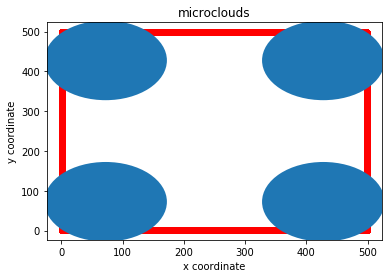

In [37]:
microcloud_coords = get_antena_coords(coords_x,coords_y,MiCROCLOUD_RANGE=MiCROCLOUD_RANGE)
plot_microclouds(microcloud_coords,MiCROCLOUD_RANGE,coords_x,coords_y)


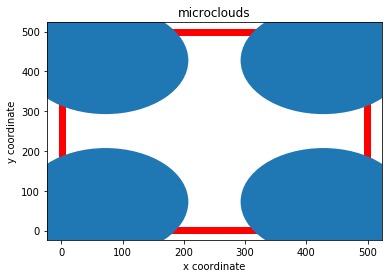

In [38]:
plot_microclouds(microcloud_coords,135,coords_x,coords_y)

Below we will test out data structures with a sample simulation with one car, one microcloud and one block for that car


In [39]:
def test():
    logging.getLogger().setLevel(logging.DEBUG)
    blocks = [Block(0,10)]
    x,y = microcloud_coords[0]
    bandwith = .01
    microcloud = Microcloud(0,x,y, MiCROCLOUD_RANGE,blocks,.01)
    node  = Node(car0_df[0:10],blocks) #Note that we sliced the rows of the df to minimize output 
    stats = node.simulate([microcloud])
    logging.debug("Stats : {}".format(stats))

In [40]:
test()

INFO:root:Id from0.0
INFO:root:Time 1.0
INFO:root:Initiated download for block 0 on car from0.0 with microcloud 0
INFO:root:Time 2.0
INFO:root:Continuing download for block 0 on car from0.0 with microcloud 0 latest progress: 0.01
INFO:root:Time 3.0
INFO:root:Continuing download for block 0 on car from0.0 with microcloud 0 latest progress: 0.02
INFO:root:Time 4.0
INFO:root:Continuing download for block 0 on car from0.0 with microcloud 0 latest progress: 0.03
INFO:root:Time 5.0
INFO:root:Continuing download for block 0 on car from0.0 with microcloud 0 latest progress: 0.04
INFO:root:Time 6.0
INFO:root:Continuing download for block 0 on car from0.0 with microcloud 0 latest progress: 0.05
INFO:root:Time 7.0
INFO:root:Continuing download for block 0 on car from0.0 with microcloud 0 latest progress: 0.060000000000000005
INFO:root:Time 8.0
INFO:root:Continuing download for block 0 on car from0.0 with microcloud 0 latest progress: 0.07
INFO:root:Time 9.0
INFO:root:Continuing download for block

Now that we have created the simulation framework and tested it with one node, one block and  one microcloud. We will now test it with one node,4 blocks and 4 microclouds

In [41]:
def test2():
    logging.getLogger().setLevel(logging.DEBUG)
    n,bandwith = 4,0.01
    blocks = [Block(n,10) for i in range(n)]
    microclouds = [Microcloud(i,microcloud_coords[i][0],microcloud_coords[i][1], MiCROCLOUD_RANGE,[blocks[i]],bandwith) for i in range(n)] 
    node  = Node(car0_df[0:40],blocks) #Note that we sliced the rows of the df to minimize output 
    stats= node.simulate(microclouds)
    logging.debug("Stats : {}".format(stats))

In [42]:
test2()

INFO:root:Id from0.0
INFO:root:Time 1.0
INFO:root:Initiated download for block 4 on car from0.0 with microcloud 0
INFO:root:Time 2.0
INFO:root:Continuing download for block 4 on car from0.0 with microcloud 0 latest progress: 0.01
INFO:root:Time 3.0
INFO:root:Continuing download for block 4 on car from0.0 with microcloud 0 latest progress: 0.02
INFO:root:Time 4.0
INFO:root:Continuing download for block 4 on car from0.0 with microcloud 0 latest progress: 0.03
INFO:root:Time 5.0
INFO:root:Continuing download for block 4 on car from0.0 with microcloud 0 latest progress: 0.04
INFO:root:Time 6.0
INFO:root:Continuing download for block 4 on car from0.0 with microcloud 0 latest progress: 0.05
INFO:root:Time 7.0
INFO:root:Continuing download for block 4 on car from0.0 with microcloud 0 latest progress: 0.060000000000000005
INFO:root:Time 8.0
INFO:root:Continuing download for block 4 on car from0.0 with microcloud 0 latest progress: 0.07
INFO:root:Time 9.0
INFO:root:Continuing download for block

Now that we have tested the simulator thoroughly we will simulate the scenario with all the cars and record the blocks download for each car. Also we will copy the blocks twice and distribute them evenly among the microclouds

In [43]:
def simulation():
    logging.getLogger().setLevel(logging.WARN)
    n = 4 #Four blocks and four microclouds
    bandwith = .65
    blocks = [Block(n,10) for i in range(n)]
    microclouds = []
    microclouds = [Microcloud(i,microcloud_coords[i][0],microcloud_coords[i][1], MiCROCLOUD_RANGE,[blocks[i],blocks[len(blocks)-1-i]],bandwith) for i in range(n)] 
    nodes = []
    for car in cars:
        car_df = car_groups.get_group(car)
        node = Node(car_df,blocks)
        nodes.append(node)
    pool = ThreadPool(8) 
    results = pool.map(lambda node:node.simulate(microclouds), nodes)
    return results

In [44]:
stats = simulation()

In [45]:
stats_df = pd.DataFrame(stats,columns=['id','blocks_received','blocks_needed'])
stats_df.head()

,id,blocks_received,blocks_needed
0,from0.0,3,4
1,from1.0,3,4
2,from2.0,3,4
3,from3.0,3,4
4,from0.1,3,4


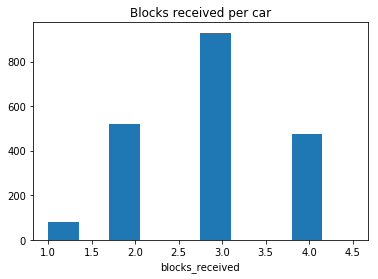

In [46]:
blocks_received = stats_df['blocks_received']
plt.xlabel("blocks_received")
plt.title("Blocks received per car")
plt.hist(stats_df['blocks_received'],range=(1,4.5))
plt.show()